In [1]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [2]:
!ls "/gdrive/My Drive/hackathon/transfer_value"

sex_inceptionv3_ver2.pkl  sex_mobilenet_ver1.pkl  sex_nas.pkl  sex_nas_ver2.pkl


In [3]:
from collections import deque
from sklearn.model_selection import train_test_split
from tflearn.data_utils import to_categorical
import tflearn
import numpy as np
import pickle
from keras.models import load_model

W0713 23:53:23.236321 140465802020736 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/tflearn/helpers/summarizer.py:9: The name tf.summary.merge is deprecated. Please use tf.compat.v1.summary.merge instead.

W0713 23:53:23.238027 140465802020736 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/tflearn/helpers/trainer.py:25: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.

W0713 23:53:23.254222 140465802020736 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/tflearn/collections.py:13: The name tf.GraphKeys is deprecated. Please use tf.compat.v1.GraphKeys instead.

W0713 23:53:23.264220 140465802020736 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/tflearn/config.py:123: The name tf.get_collection is deprecated. Please use tf.compat.v1.get_collection instead.

W0713 23:53:23.282374 140465802020736 deprecation_wrapper.py:119] From /usr/local/lib/

In [0]:
num_frames_per_segment = 64
input_length = 1000
# input_length = 4032
num_classes = 2

In [5]:
X, y = [], []
with open("/gdrive/My Drive/hackathon/transfer_value/sex_mobilenet_ver1.pkl","rb") as f:
  unpickler = pickle.Unpickler(f)
  pkl = unpickler.load()
  data = pkl['data']
  label = pkl['label']
  print(len(data), len(label))
  for i in range(len(data)):
    X.append(np.array(data[i]))
    y.append(label[i])
  f.close()
X = np.array(X)
# Y = np.array(y)
print(y[:5], y[-5:])
X = X.reshape(-1, num_frames_per_segment, input_length)
temp_y = []
for i in range(len(X)):
  temp_y.append(y[(i+1)*num_frames_per_segment-1])

y = np.array(temp_y)
y = to_categorical(y, num_classes)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

84096 84096
[1, 1, 1, 1, 1] [0, 0, 0, 0, 0]


In [6]:
y = np.array(temp_y)
unique, counts = np.unique(y, return_counts=True)
print(unique, counts)

[0 1] [832 482]


In [7]:
print(len(y))

1314


In [0]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Reshape
from keras.layers import LSTM, GRU, TimeDistributed
from keras.layers import Input, Dense, Bidirectional
from keras.layers.embeddings import Embedding
import tensorflow as tf
import keras.backend as K

C1 = 3
C2 = 1

def weighted_binary_crossentropy(targets, output):
    """
    Weighted binary crossentropy between an output tensor
    and a target tensor. POS_WEIGHT is used as a multiplier
    for the positive targets.

    Combination of the following functions:
    * keras.losses.binary_crossentropy
    * keras.backend.tensorflow_backend.binary_crossentropy
    * tf.nn.weighted_cross_entropy_with_logits
    """
    # # transform back to logits
    # _epsilon = tfb._to_tensor(tfb.epsilon(), output.dtype.base_dtype)
    # output = tf.clip_by_value(output, _epsilon, 1 - _epsilon)
    # output = tf.log(output / (1 - output))
    # # compute weighted loss
    # loss = tf.nn.weighted_cross_entropy_with_logits(targets=target,
    #                                                 logits=output,
    #                                                 pos_weight=POS_WEIGHT)
    # return tf.reduce_mean(loss, axis=-1)
    return tf.reduce_mean(
        -targets*tf.log(output+K.epsilon())*C1 - (1-targets)*tf.log(1 - output+K.epsilon())*C2,
        axis=-1
    )

def lstm_model(time_steps=64, input_length=1000, num_class=2):
  
#   lstm_1 = Bidirectional(LSTM(256, return_sequences=True, name='lstm1',dropout=0.25, recurrent_dropout=0.25))
  model = Sequential()
  model.add(Bidirectional(LSTM(1024, return_sequences=False, name='lstm1', dropout=0.5, recurrent_dropout=0.5)))
#   model.add(LSTM(64, input_shape=(time_steps, input_length), return_sequences=False))
#   model.add(Dropout(0.3))
#   model.add(LSTM(64, return_sequences = True))
#   model.add(Dropout(0.3))
#   model.add(LSTM(64))
#   model.add(Dropout(0.3))
#   model.add(Dense(128))
#   model.add(Activation('relu'))
#   model.add(Dropout(0.3))
  model.add(Dense(512))
#   model.add(Dropout(0.3))
  model.add(Activation('relu'))
  model.add(Dense(num_class))
  model.add(Activation('softmax'))
  model.compile(loss=weighted_binary_crossentropy, optimizer='adam',metrics=['accuracy'])
  return model  
  

In [0]:
from keras.utils import plot_model
model = lstm_model(input_length=1000)
plot_model(model, to_file='model.png')

In [0]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
pat = 10 #this is the number of epochs with no improvment after which the training will stop
early_stopping = EarlyStopping(monitor='val_acc', patience=pat, verbose=1)
#define the model checkpoint callback -> this will keep on saving the model as a physical file
model_checkpoint = ModelCheckpoint('/gdrive/My Drive/hackathon/model_mobilenet_ver4.h5', verbose=1, save_best_only=True)

In [0]:
def fit_and_evaluate(t_x, val_x, t_y, val_y, EPOCHS=20, BATCH_SIZE=64):
    model = None
    model = lstm_model()
    results = model.fit(t_x, t_y, validation_data=(val_x, val_y), epochs=EPOCHS, batch_size=BATCH_SIZE, 
                        callbacks=[early_stopping, model_checkpoint], verbose=1)  
    test_score = model.evaluate(X_test, y_test)
    print("Test Score: ", test_score)
    print(model.metrics_names)
    return results

In [29]:
epochs_per_fold = 100
batch_size = 32
n_folds = 1

model_history = [] 
random_sates = [20, 40, 60, 80, 100, 120, 140, 160, 180, 200]

for i in range(1):
  print("Training on Fold: ",i+1)
  t_x, val_x, t_y, val_y = train_test_split(X_train, y_train, test_size=1/10, 
                                             random_state = random_sates[i])
  model_history.append(fit_and_evaluate(t_x, val_x, t_y, val_y, epochs_per_fold, batch_size))
  print("======="*12, end="\n\n\n")

Training on Fold:  1
Train on 1063 samples, validate on 119 samples
Epoch 1/100
1063/1063 [==============================] - 12s 12ms/step - loss: 1.7348 - acc: 0.5880 - val_loss: 1.2217 - val_acc: 0.6639

Epoch 00001: val_loss improved from inf to 1.22173, saving model to /gdrive/My Drive/hackathon/model_mobilenet_ver4.h5
Epoch 2/100
1063/1063 [==============================] - 9s 9ms/step - loss: 1.2808 - acc: 0.6246 - val_loss: 1.1592 - val_acc: 0.6639

Epoch 00002: val_loss improved from 1.22173 to 1.15919, saving model to /gdrive/My Drive/hackathon/model_mobilenet_ver4.h5
Epoch 3/100
1063/1063 [==============================] - 9s 8ms/step - loss: 1.1846 - acc: 0.6783 - val_loss: 1.0478 - val_acc: 0.7815

Epoch 00003: val_loss improved from 1.15919 to 1.04784, saving model to /gdrive/My Drive/hackathon/model_mobilenet_ver4.h5
Epoch 4/100
1063/1063 [==============================] - 9s 8ms/step - loss: 1.0915 - acc: 0.7187 - val_loss: 1.0572 - val_acc: 0.7563

Epoch 00004: val_loss

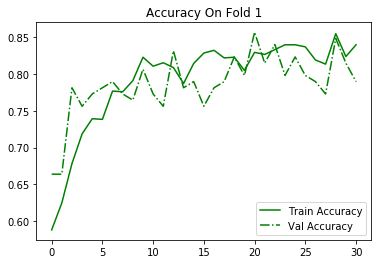

In [30]:
import matplotlib.pyplot as plt
for i in range(len(model_history)):
  plt.title('Accuracy On Fold %d'%(i+1))
  plt.plot(model_history[i].history['acc'], label='Train Accuracy', color='green')
  plt.plot(model_history[i].history['val_acc'], label='Val Accuracy', color='green', linestyle = "dashdot")
  plt.legend()
  plt.show()

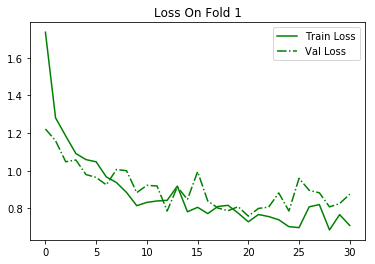

In [31]:
for i in range(len(model_history)):
  plt.title('Loss On Fold %d'%(i+1))
  plt.plot(model_history[i].history['loss'], label='Train Loss', color='green')
  plt.plot(model_history[i].history['val_loss'], label='Val Loss', color='green', linestyle = "dashdot")
  plt.legend()
  plt.show()

In [28]:
fit_and_evaluate(t_x, val_x, t_y, val_y, EPOCHS=1, BATCH_SIZE=64)

Train on 1063 samples, validate on 119 samples
Epoch 1/1
1063/1063 [==============================] - 9s 8ms/step - loss: 1.5272 - acc: 0.6021 - val_loss: 1.1572 - val_acc: 0.6807

Epoch 00001: val_loss did not improve from 0.70212
132/132 [==============================] - 1s 5ms/step
Test Score:  [1.170954097401012, 0.696969696969697]
['loss', 'acc']


In [0]:
model = load_model('/gdrive/My Drive/hackathon/model.h5')

In [0]:
print(model.evaluate(X_test, y_test))

153/153 [==============================] - 1s 7ms/step
[0.13638965800112368, 0.9281045778904086]
